In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [8]:
## put your path to your vape repo here 
path_to_vape = os.path.expanduser('~/Documents/code/Vape/')
popoff_path = '/home/jrowland/Documents/code/pop-off/scripts/'

# Bit hacky but oh well
sys.path.append(path_to_vape)
sys.path.append(os.path.join(path_to_vape, 'utils'))
sys.path.append(popoff_path)

from utils.utils_funcs import d_prime

In [9]:
import utils.utils_funcs as uf
from subsets_analysis import Subsets
import pickle
import popoff

from Session import Session, SessionLite, build_flu_array_single

pkl_path = os.path.expanduser('~/mnt/qnap/run_pkls/')

/home/jrowland/Documents/code/pop-off/popoff/popoff/loadpaths.py
/home/jrowland/Documents/code/Vape


In [10]:
def load_run(mouse, run_number, base_path):
    pkl_path = os.path.join(base_path, mouse, f'run{run_number}.pkl')
    with open(pkl_path, 'rb') as f:
        run = pickle.load(f)
    return run

In [154]:
mouse = 'RL123'
run_number = 22

run = load_run(mouse, run_number, pkl_path)
session = SessionLite(mouse, run_number, pkl_path, 'flu', pre_gap_seconds=0, post_gap_seconds=0)
times_use = session.filter_ps_time
flu = session.behaviour_trials

Now loading mouse RL123, run 22
/home/jrowland/mnt/qnap/run_pkls/RL123/run22.pkl
microcontroller trial starts occur on average -81.19 ms from galvo trial starts
photo stim occurences: {0: 61, 1: 64, 2: 75}
Occurence table:
[[41. 20.]
 [24. 40.]
 [17. 58.]]
58 / 552 cells filtered
Stim radius for targets is 17.5
WARNING S1 TARGET CHECKER DISABLED
178 / 178 non nan trials identified
Numbers of PS cells: [  0   5  10  20  30  40  50 150]


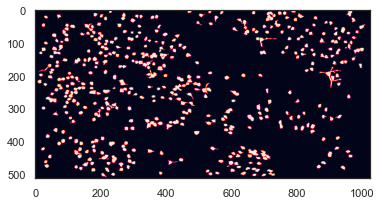

In [155]:
im = np.zeros((514, 1024))
for s in run.stat[session.filtered_neurons]:
    im[s['ypix'], s['xpix']] = 1
    
plt.imshow(im)

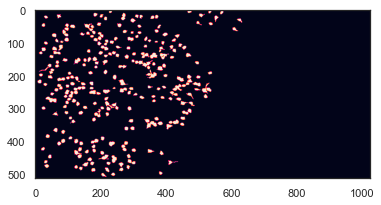

In [156]:
im = np.zeros((514, 1024))
for s in run.stat[session.filtered_neurons][session.s1_bool]:
    im[s['ypix'], s['xpix']] = 1
    
plt.imshow(im)

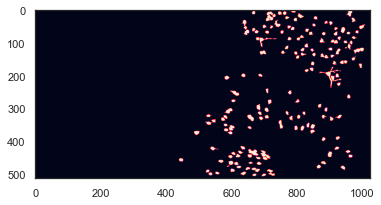

In [158]:
im = np.zeros((514, 1024))
for s in run.stat[session.filtered_neurons][session.s2_bool]:
    im[s['ypix'], s['xpix']] = 1
    
plt.imshow(im)

In [159]:


with open('/home/jrowland/Documents/code/Vape/s2_position.json') as json_file:
    s1s2_border_json = json.load(json_file)
    
s1s2_border = s1s2_border_json[mouse][str(run_number)]

# self.s2_bool = self.av_xpix > self.s1s2_border
# self.s1_bool = np.logical_not(self.s2_bool)


In [160]:
s1s2_border

[654, -2, 404, 514]

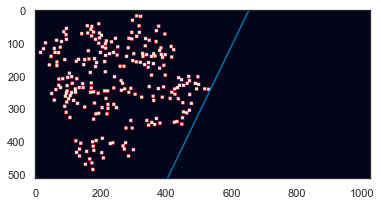

In [161]:
im = np.zeros((514,1024))

ever_targeted = np.any(session.is_target, axis=(1,2))

if isinstance(s1s2_border, list):
    x1, y1, x2, y2 = s1s2_border
    plt.plot([x1, x2], [y1, y2])
else:
    plt.axvline(s1s2_border)


bool_ = ever_targeted
for x,y in zip(session.av_xpix[bool_], session.av_ypix[bool_]):
    x = int(x)
    y = int(y)
    im[y-5:y+5, x-5:x+5] = 1

plt.imshow(im)

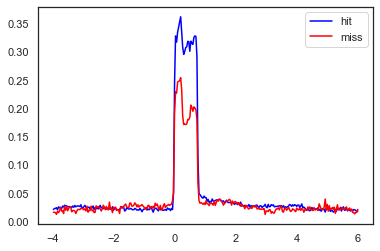

In [162]:
plt.plot(times_use, np.mean(session.behaviour_trials[:, session.outcome=='hit', :], (0,1)), color='blue', label='hit')
plt.plot(times_use, np.mean(session.behaviour_trials[:, session.outcome=='miss', :], (0,1)), color='red', label='miss')
# plt.plot(times_use, np.mean(session.behaviour_trials[:, session.outcome=='fp', :], (0,1)), color='green')
# plt.plot(times_use, np.mean(session.behaviour_trials[:, session.outcome=='cr', :], (0,1)), color='black')

plt.legend()

In [163]:
def get_plot_trace(session, targets=False, region='s1', remove_easy=False):
    
    if targets:
        mask = ~session.is_target
    else:
        mask = session.is_target
    
    # Fluoresence averaged across cells with (non)targets filtered
    flu = session.behaviour_trials
    flu = np.ma.array(flu, mask=mask).mean((0,1))
    
    # x axis in seconds aligned to stim
    plt.plot(flu, label=f'targets = {targets}')
    plt.legend()

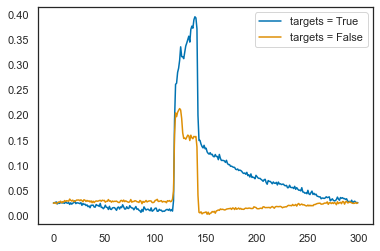

In [164]:
get_plot_trace(session, targets=True)
get_plot_trace(session, targets=False)


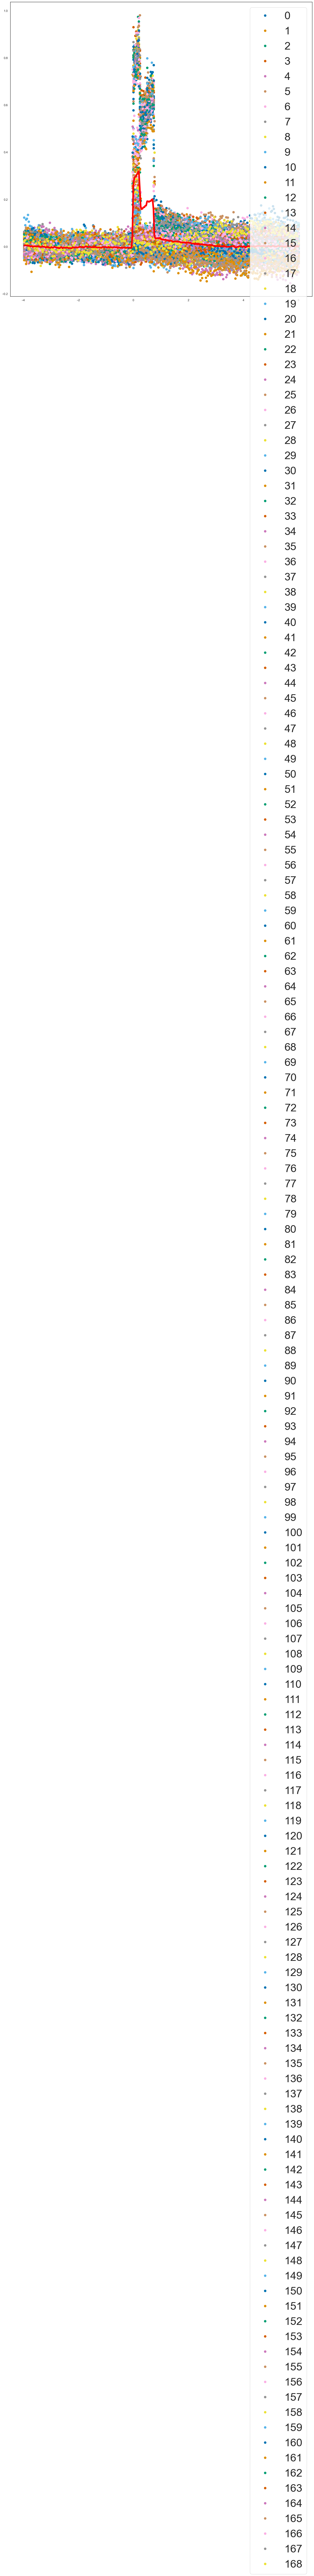

In [30]:
x_axis = session.filter_ps_time
plt.figure(figsize=(20,20))
arr = np.mean(session.behaviour_trials[:, session.outcome!='podksa', :], 0)
baseline = np.mean(arr[:, :session.pre_frames], 1)
arr = np.subtract(arr.T, baseline).T
# arr = np.sort(arr, 0)

for idx, t in enumerate(arr):
    
    plt.plot(x_axis, t, '.', label=idx, markersize=16)
        
        
        
plt.legend(fontsize=40)
plt.plot(x_axis, np.mean(arr, 0), color='red', linewidth=6)
# plt.ylim(-0.1,0.05)
# plt.xlim(-0.2,0.1)

# Check the psychometric single session

In [9]:
def get_subset_dprime(session):
    
    assert session.trial_subsets.shape == session.outcome.shape
    
    fp_rate = sum(session.outcome=='fp') / (sum(session.outcome=='fp') + sum(session.outcome=='cr'))
    subset_dprimes = []
#     for subset in [[5, 10], [20, 30], [40, 50], [150]]:
    for subset in [[5],[10],[20],[30],[40],[50], [150]]:
        idx = np.isin(session.trial_subsets, subset)
        outcome = session.outcome[idx]
        hit_rate = sum(outcome=='hit') / (sum(outcome=='hit') + sum(outcome=='miss'))
        subset_dprimes.append(d_prime(hit_rate, fp_rate))
#         subset_dprimes.append(hit_rate)
    
    return subset_dprimes

In [10]:
subset_dprimes = get_subset_dprime(session)

Text(0, 0.5, 'dprime')

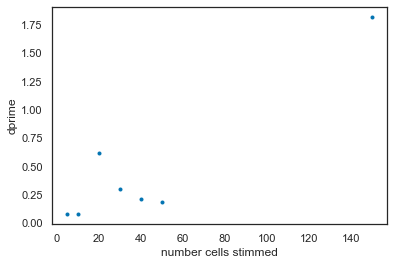

In [11]:
plt.plot([5,10,20,30,40,50,150], subset_dprimes, '.')
plt.xlabel("number cells stimmed")
plt.ylabel('dprime')

# Check the psychometric all sessions

In [6]:
good_sessions = {
    
    'J064': [10,11,14],
    'RL070': [28,29],
    'RL117': [29,30],
    'RL123': [22],
    'RL116': [32,33],
    
}

good_sessions

{'J064': [10, 11, 14],
 'RL070': [28, 29],
 'RL117': [29, 30],
 'RL123': [22],
 'RL116': [32, 33]}

In [7]:
sessions = []

for mouse, run_numbers in good_sessions.items():
    
    for run_number in run_numbers:
        run = load_run(mouse, run_number, pkl_path)
        session = SessionLite(mouse, run_number, pkl_path, 'flu', pre_gap_seconds=0, post_gap_seconds=0)
        sessions.append(session)

Now loading mouse J064, run 10
/home/jrowland/mnt/qnap/run_pkls/J064/run10.pkl
microcontroller trial starts occur on average nan ms from galvo trial starts
photo stim occurences: {0: 66, 1: 58, 2: 49}
Occurence table:
[[38. 28.]
 [20. 38.]
 [ 6. 43.]]
6 / 477 cells filtered
STIM RADIUS FOR TARGET REDUCED FIXED IN FUTURE
163 / 163 non nan trials identified
Numbers of PS cells: [  0   5  10  20  30  40  50 150]
Now loading mouse J064, run 11
/home/jrowland/mnt/qnap/run_pkls/J064/run11.pkl
microcontroller trial starts occur on average -52.47 ms from galvo trial starts
photo stim occurences: {0: 46, 1: 66, 2: 64}
Occurence table:
[[33. 13.]
 [26. 40.]
 [ 8. 56.]]
14 / 802 cells filtered
STIM RADIUS FOR TARGET REDUCED FIXED IN FUTURE
167 / 167 non nan trials identified
Numbers of PS cells: [  0   5  10  20  30  40  50 150]
Now loading mouse J064, run 14
/home/jrowland/mnt/qnap/run_pkls/J064/run14.pkl
microcontroller trial starts occur on average nan ms from galvo trial starts
photo stim occ

In [13]:
subset_dprimes = [get_subset_dprime(session) for session in sessions]
subset_dprimes = np.array(subset_dprimes)

# psychometric function
def pf(x, max_value, alpha, beta):
    ''' Max value: max value of sigmoid
        alpha: x_axis midpoint
        beta: the growth rate
    '''
    return max_value / (1 + np.exp( -(x-alpha)/beta))

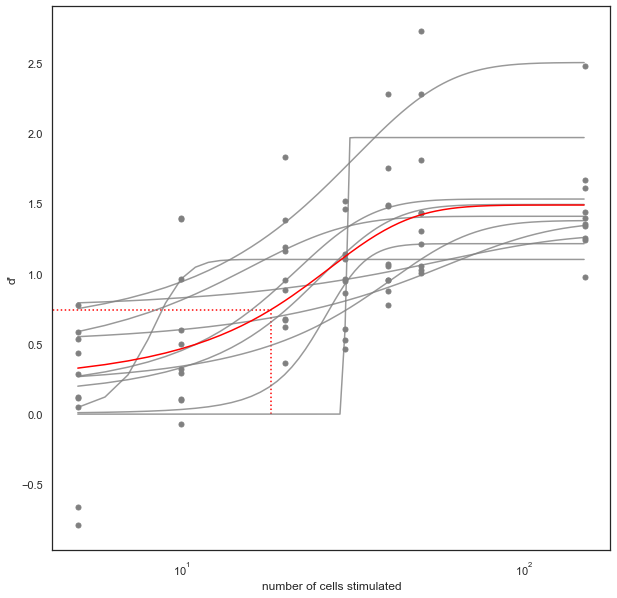

In [14]:
np.seterr(divide='ignore')  # Ugly division by 0 error
plt.figure(figsize=(10,10))

# x_axis = [7.5, 25, 45, 150]
x_axis = [5,10,20,30,40,50,150]
all_dp = []
n = 0

min_x = 5
for idx, dp in enumerate(subset_dprimes):
    
    all_dp.append(dp)
    plt.plot(x_axis, dp, '.', color='grey', alpha=1, markersize=10)
    
    popt, pcov = curve_fit(pf, x_axis, dp, method='dogbox', p0=[max(dp), 50, 200])
    
    plt.plot(np.arange(min_x ,max(x_axis)), pf(np.arange(min_x, max(x_axis)), *popt), color='grey', alpha=0.8)
    plt.xscale('log')
    
y = np.concatenate(all_dp)
x = np.tile(x_axis, subset_dprimes.shape[0])
popt, pcov = curve_fit(pf, x, y, method='dogbox', p0=[max(y), 50, 200])
plt.plot(np.arange(min_x, max(x_axis)), pf(np.arange(min_x, max(x_axis)), *popt), color='red')

plt.xscale('log')
plt.ylabel('d\'')
plt.xlabel('number of cells stimulated', fontname='Arial')

ticks = [5, int(popt[1]), 100, 150]
ticks = [10,100]

# plt.axvline(x=popt[1], ymax=popt[0]/2, color='red', ls=':')
plt.vlines(x=popt[1], ymin=0, ymax=popt[0]/2, color='red', ls=':')
plt.hlines(y=popt[0]/2, xmin=0, xmax=popt[1], color='red', ls=':')

plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.gca().tick_params(which='minor', length=1, color='r')


# save_figure('psychos')


In [17]:
np.sort(subset_dprimes.ravel())

array([-0.79210816, -0.66173354, -0.06837306,  0.04798831,  0.10291203,
        0.10678936,  0.11386978,  0.12347335,  0.28369462,  0.29408013,
        0.32399669,  0.36265873,  0.43321699,  0.46377549,  0.50111727,
        0.52688831,  0.53751626,  0.58815988,  0.59978479,  0.6053127 ,
        0.62401244,  0.66885636,  0.67413538,  0.77738298,  0.77812807,
        0.86406012,  0.87670537,  0.88489689,  0.95123335,  0.95761522,
        0.95761522,  0.95832517,  0.96325286,  0.96325286,  0.97844243,
        1.00758551,  1.02917188,  1.05190166,  1.05190166,  1.06947395,
        1.10346059,  1.13817548,  1.16043146,  1.19244202,  1.21198476,
        1.23983135,  1.25556785,  1.30637085,  1.34150418,  1.35661941,
        1.38108855,  1.38834212,  1.3944996 ,  1.39567352,  1.43063579,
        1.43370542,  1.44059502,  1.45825769,  1.48300851,  1.49263374,
        1.52112905,  1.60877467,  1.66664439,  1.75467835,  1.81268715,
        1.8305798 ,  2.27698044,  2.27698044,  2.47935545,  2.72

In [15]:
popt[1]

18.27246180448075

In [20]:
for session in sessions:
    print(session)
    print(len(session.outcome))
    print('\n')

Mouse J064, run 10
163


Mouse J064, run 11
167


Mouse J064, run 14
208


Mouse RL070, run 28
375


Mouse RL070, run 29
263


Mouse RL117, run 29
262


Mouse RL117, run 30
194


Mouse RL123, run 22
178


Mouse RL116, run 32
315


Mouse RL116, run 33
216


